In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [12]:
ODIR_PATH = '../ODIR-5K/ODIR-5K/Training Images/'
BRSET_PATH = '../a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.1/fundus_photos/'
TRAINING_FOLDER = '../train_data/'
TESTING_FOLDER = '../test_data/'

: 

In [3]:
data = pd.read_csv('combined_dataset.csv')
data.sample(5)

,image_id,patient_id,patient_age,patient_sex,exam_eye,diabetic_retinopathy,macular_edema,scar,nevus,amd,...,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,other,data_source,normal_eye,glaucoma,cataract
16965,4229_right.jpg,12754,64.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,ODIR,0,0,0
4422,img06009.jpg,3161,53.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,BRSET,0,0,0
10908,44_left.jpg,8569,55.0,2,2,1,0,0,0,0,...,0,0,0,0,0,0,ODIR,0,0,0
11014,97_left.jpg,8622,64.0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,ODIR,1,0,0
13024,1146_left.jpg,9671,59.0,2,2,0,0,0,0,0,...,0,0,0,0,0,1,ODIR,0,0,0


In [4]:
def find_img_path(image_id, data_sourse):
    if data_sourse == 'ODIR':
        path = os.path.join(ODIR_PATH, image_id)
    else:
        path = os.path.join(BRSET_PATH, image_id)
    return path

def open_img(directory_path, input_filename):
    image_path = os.path.join(directory_path, input_filename)
    image = cv2.imread(image_path)
    return image

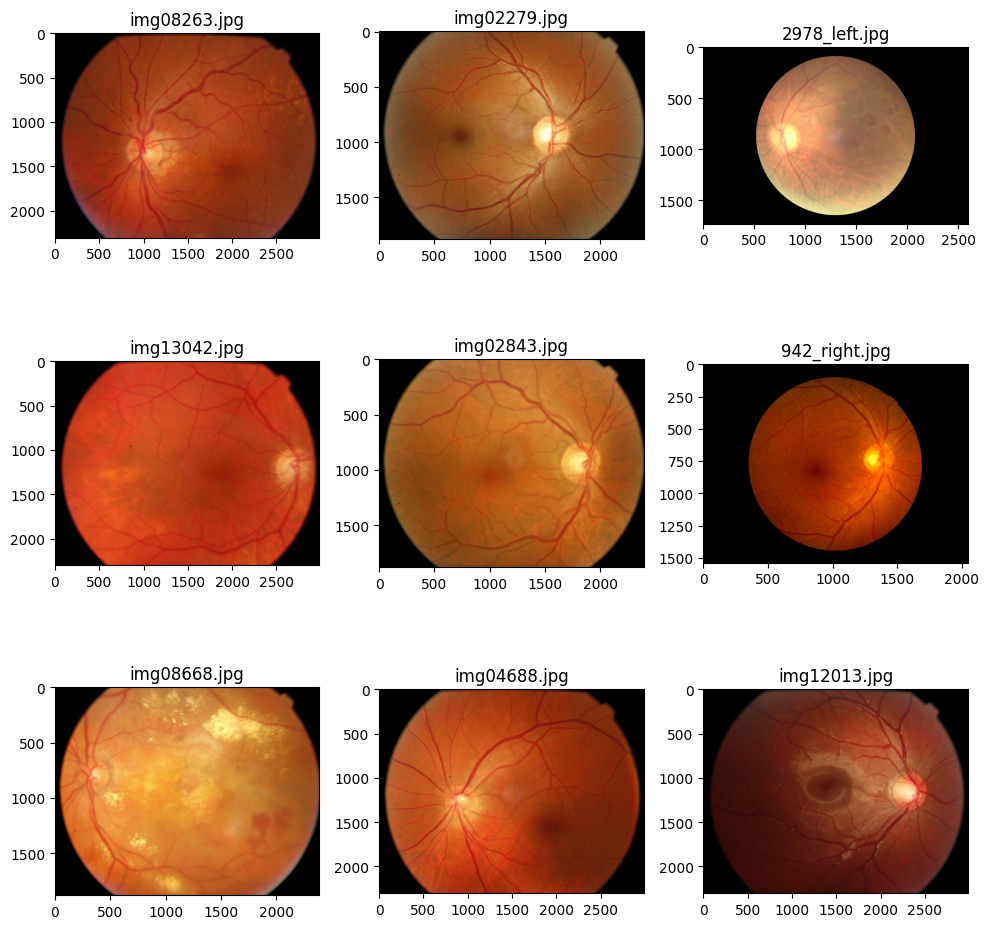

In [5]:
data_sample = data.sample(9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
indx = 0
for index, row in data_sample.iterrows():
    path = find_img_path(row['image_id'], row['data_source'])
    image = cv2.imread(path)
    # print(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[indx // 3][indx % 3].imshow(image_rgb)
    axes[indx // 3][indx % 3].set_title(row['image_id'])
    indx += 1
plt.grid(False)    
plt.tight_layout() 

In [126]:
data_sample

,image_id,patient_id,patient_age,patient_sex,exam_eye,diabetic_retinopathy,macular_edema,scar,nevus,amd,...,hypertensive_retinopathy,drusens,hemorrhage,retinal_detachment,myopic_fundus,other,data_source,normal_eye,glaucoma,cataract
15377,2917_right.jpg,11442,48.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,ODIR,1,0,0
12185,684_right.jpg,9209,60.0,2,1,1,0,0,0,0,...,0,0,0,0,0,0,ODIR,0,0,0
7451,img11322.jpg,5953,52.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,BRSET,0,0,0
3813,img05269.jpg,2779,69.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,BRSET,0,0,0
17469,4501_right.jpg,13026,62.0,2,1,1,0,0,0,0,...,0,0,0,0,0,0,ODIR,0,0,0
17582,4568_left.jpg,13093,54.0,1,2,1,0,0,0,0,...,0,0,0,0,0,0,ODIR,0,0,0
13869,2004_right.jpg,10529,47.0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,ODIR,0,0,0
1026,img01070.jpg,556,66.0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,BRSET,0,0,0
6136,img08943.jpg,4697,83.0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,BRSET,0,0,0


In [9]:
def crop_image_to_circle(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, None, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = image[y:y + h, x:x + w]
        return cropped_image
    return False

# crop_image_to_circle(os.path.join(ODIR_PATH, "2917_right.jpg"), "test.jpg")

In [6]:
def preprocess(image, size_x=224, size_y=224):
    # cropping
    final_image = crop_image_to_circle(image)
    
    # blurring for reducing noise
    final_image = cv2.bilateralFilter(final_image, d=5, sigmaColor=75, sigmaSpace=75)
    # CLACHE in green channel
    green_channel = final_image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_green_channel = clahe.apply(green_channel)
    final_image[:, :, 1] = enhanced_green_channel
    
    #resizing
    final_image = cv2.resize(final_image, (size_x, size_y), interpolation=cv2.INTER_LINEAR)
    
    # # saving
    # if not os.path.exists(output_path):
    #     os.makedirs(output_path)
    # cv2.imwrite(os.path.join(output_path, output_filename))
    return final_image

def save_pic(image, output_filename, output_path="preprocessed_images"):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    cv2.imwrite(os.path.join(output_path, output_filename), image)

Example

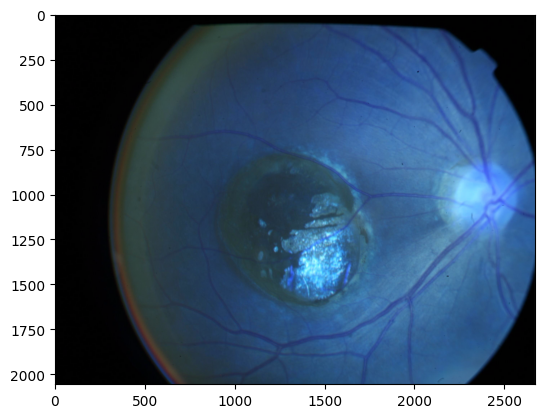

In [7]:
test_pic = cv2.imread(os.path.join(BRSET_PATH, "img02140.jpg"))

plt.imshow(test_pic)

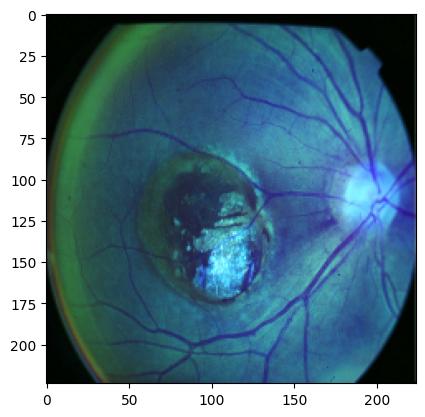

In [10]:
image = open_img(BRSET_PATH, "img02140.jpg")
final = preprocess(image)
plt.imshow(final)